# Dogtor dog's temporal COVID19 polynomial regression

<img src="https://s14-eu5.startpage.com/cgi-bin/serveimage?url=https:%2F%2Fsteamuserimages-a.akamaihd.net%2Fugc%2F272841093784221615%2F948967DA5537466A9509113E12C237641EB1506D%2F&sp=9ce3481ad1247d4f63b90d00de600702" alt="The Man himself" style="width:250px;height:200px;">

<p>This is a 2D visualization of polynomial regression on temporal COVID19 epidemiological data available from: <strike><a href="https://www.acdc.com/">acdc</a></strike>, <a href="https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide">ecdc</a>.</p>

<p>I wouldn't trust the predictions of polynomial regression though.</p>

## Reading in the data

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv") 

### Preprocessing

In [6]:
countrylist = df["countriesAndTerritories"].unique()
dflist = pd.DataFrame(columns = ["dateRep", "cases", "deaths", "popData2019", "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000", "country", "cumCases", "cumDeaths", "runDate"])
for country in countrylist:
    dfcountry = df[["dateRep","cases", "deaths", "popData2019", "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000"]][df["countriesAndTerritories"] == country]
    dfcountry['country'] = country
    dfcountry = dfcountry.iloc[::-1]
    dfcountry["cumCases"] = dfcountry["cases"].cumsum(axis = 0, skipna = True)
    dfcountry["cumDeaths"] = dfcountry["deaths"].cumsum(axis = 0, skipna = True)
    dfcountry["dateRep"] = dfcountry["dateRep"].astype("str")
    dfcountry["runDate"] = list(range(len(dfcountry)))
    dflist = dflist.append(dfcountry)

### Correlation analysis

C:\Users\simory\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\tight_layout.py:181: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



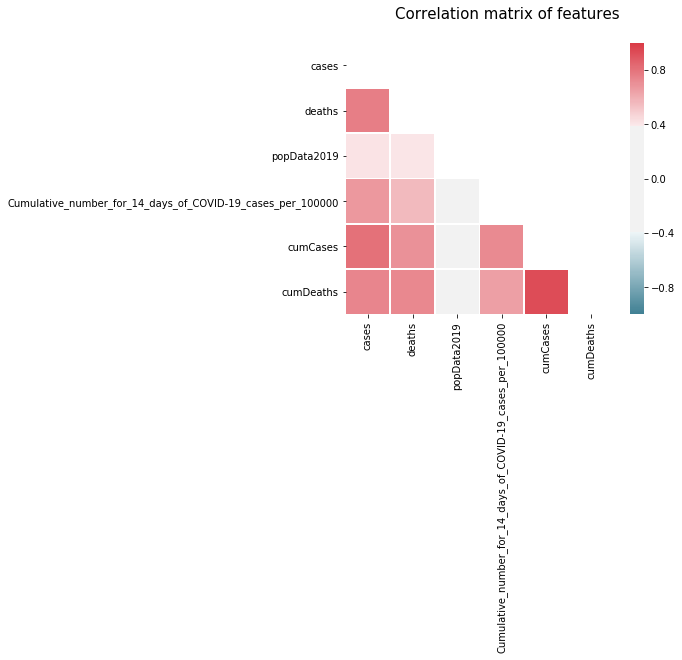

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

dflist[["cases", "deaths", "popData2019", "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000", "cumCases", "cumDeaths"]] = dflist[["cases", "deaths", "popData2019", "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000", "cumCases", "cumDeaths"]].astype("float64")
corr = dflist[["cases", "deaths", "popData2019", "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000", "cumCases", "cumDeaths"]].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

fig.suptitle('Correlation matrix of features', fontsize=15)

fig.tight_layout()

## Polynomial regression on COVID-19 data

In [13]:
from __future__ import print_function

# Fitting Polynomial Regression to the dataset 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
from ipywidgets import interact
import ipywidgets as widgets
import plotly.graph_objects as go

lin = LinearRegression() 

def plotti(country, case, poly_degree, future_prediction):

    if case == "cases":
        index = 1
    elif case == "deaths":
        index = 2
    elif case == "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000":
        index = 4
    elif case == "cumCases":
        index = 6
    else:
        index = 7
        

    figCases = go.Figure()

    dflist2 = dflist[dflist.country == country].dropna()
    
    X = dflist2.iloc[:, 8:9].values 
    y = dflist2.iloc[:, index].values 

    lin.fit(X, y) 

    poly = PolynomialFeatures(degree = poly_degree) 
    X_poly = poly.fit_transform(X) 

    poly.fit(X_poly, y) 
    lin2 = LinearRegression() 
    lin2.fit(X_poly, y) 

    # Visualising the Polynomial Regression results 
    plt.scatter(X, y, color = 'blue') 

    print(country + " polynomial model R^2: " + str(round(r2_score(y, lin2.predict(poly.fit_transform(X))), 4)))

    values = [x for x in range(len(X)+1, len(X)+future_prediction)]
    X = np.append(X, values).reshape(-1, 1)

    plt.plot(X, lin2.predict(poly.fit_transform(X)), color = 'red') 
    plt.title('Polynomial Regression') 
    plt.xlabel('Days') 
    plt.ylabel('Cases') 


    plt.show()

    figCases.add_trace(go.Scatter(x=X.squeeze(), y=y,
                            mode='markers',
                            name=country + " " + case))

    figCases.add_trace(go.Scatter(x=X.squeeze(), y=lin2.predict(poly.fit_transform(X)),
                            mode='lines',
                            name=country + ' predictions'))

    figCases.update_layout(title = country + " " + case)
    figCases.show()
    
interact(plotti, country=widgets.Dropdown(options=df["countriesAndTerritories"].unique(), value="Finland"), case=["cases", "deaths", "cumCases", "cumDeaths", "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000"], poly_degree=(1,6,1), future_prediction=(0, 120, 1));

interactive(children=(Dropdown(description='country', index=69, options=('Afghanistan', 'Albania', 'Algeria', …